Nick Clifford

# Sentiment Analysis

# Setup

In [290]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly_express as px
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [192]:
sns.set()
%matplotlib inline

analyser = SentimentIntensityAnalyzer()
emo_cols = "anger anticipation disgust fear joy sadness surprise trust polarity".split()

In [350]:
OHCO = ['county', 'author', 'year', 'month', 'day', 'doc_id', 'page_num', 'para_num', 'sent_num', 'token_num']
COUNTY = OHCO[:1]
AUTHOR = OHCO[:2]
YEAR = OHCO[:3]
MONTH = OHCO[:4]
DAY = OHCO[:5]
DOCS = OHCO[:6]
PAGES = OHCO[:7]
PARAS = OHCO[:8]
SENTS = OHCO[:9]

datadir = '/Users/nickclifford/Documents/UVA/Spring 2020/DS 5001 Exploratory Text Analysis/final/data/'
table_out = datadir + 'tables/'

salex_csv = datadir + 'tables/salex_nrc.csv'
LIB = pd.read_csv(datadir + 'tables/LIB_mod.csv', parse_dates=['date']).set_index('doc_id')
TOKEN = pd.read_csv(datadir + 'tables/TOKEN_mod.csv').set_index('doc_id')
VOCAB = pd.read_csv(datadir + 'tables/VOCAB_mod.csv').set_index('term_id')

In [351]:
TOKEN = TOKEN.merge(LIB[['author', 'county']], left_index=True, right_index=True)
TOKEN['year'] = LIB.date.dt.year
TOKEN['month'] = LIB.date.dt.month
TOKEN['day'] = LIB.date.dt.day
TOKEN = TOKEN.reset_index().set_index(OHCO)
TOKEN.head()

pos_tuple  \
county  author          year   month day  doc_id page_num para_num sent_num token_num                       
Augusta L. M. Blackford 1863.0 6.0   28.0 A0001  1        9        0        0               ('He', 'PRP')   
                                                                            1              ('Qrs', 'NNP')   
                                                                   1        0          ('Military', 'JJ')   
                                                                            1            ('Court', 'NNP')   
                                                                            3               ('1st', 'CD')   

                                                                                       pos  \
county  author          year   month day  doc_id page_num para_num sent_num token_num        
Augusta L. M. Blackford 1863.0 6.0   28.0 A0001  1        9        0        0          PRP   
                                                                            1          NNP   
                                                                   1        0           JJ   
                                                                            1          NNP   
                                                                            3           CD   

                                                                                      token_str  \
county  author          year   month day  doc_id page_num para_num sent_num token_num             
Augusta L. M. Blackford 1863.0 6.0   28.0 A0001  1        9        0        0                He   
                                                                            1               Qrs   
                                                                   1        0          Military   
                                                                            1             Court   
                                                                            3               1st   

                                                                                       term_str  \
county  author          year   month day  doc_id page_num para_num sent_num token_num             
Augusta L. M. Blackford 1863.0 6.0   28.0 A0001  1        9        0        0                he   
                                                                            1               qrs   
                                                                   1        0          military   
                                                                            1             court   
                                                                            3               1st   

                                                                                       term_id  \
county  author          year   month day  doc_id page_num para_num sent_num token_num            
Augusta L. M. Blackford 1863.0 6.0   28.0 A0001  1        9        0        0            10290   
                                                                            1            17261   
                                                                   1        0            14109   
                                                                            1             5413   
                                                                            3              226   

                                                                                      stem_porter  
county  author          year   month day  doc_id page_num para_num sent_num token_num              
Augusta L. M. Blackford 1863.0 6.0   28.0 A0001  1        9        0        0                  he  
                                                                            1                  qr  
                                                                   1        0            militari  
                                                                            1               court 

# Bag of Words Table

In [352]:
bag = PAGES

BOW = TOKEN.groupby(bag+['term_id']).term_id.count()\
.to_frame().rename(columns={'term_id':'n'}).reset_index()
BOW['c'] = BOW.n.astype('bool').astype('int')
# add term_str 
BOW['term_str'] = BOW.term_id.map(VOCAB.term_str)
BOW = BOW.set_index(PAGES + ['term_id'])

Create TFIDF to append tfidf field to `BOW` table

In [353]:
DTCM = BOW['n'].unstack().fillna(0).astype('int')

TF = DTCM.T / DTCM.T.sum()
TF = TF.T
DF = DTCM[DTCM > 0].count()
N = DTCM.shape[0]

IDF = np.log10(N / DF)

TFIDF = TF * IDF

In [354]:
%%time
BOW['tf'] = TF.stack()
BOW['tfidf'] = TFIDF.stack()

CPU times: user 1min 34s, sys: 1min 33s, total: 3min 7s
Wall time: 5min 14s


In [355]:
BOW.sort_index()

n  \
county  author                             year   month day  doc_id page_num term_id      
Augusta (probably L. [Letitia?] R. Smiley) 1866.0 11.0  24.0 A1114  1        49       1   
                                                                             610      4   
                                                                             1033     1   
                                                                             1191     1   
                                                                             1406     8   
...                                                                                  ..   
Other   Royster, Iowa                      1863.0 6.0   29.0 F1716  1        23978    1   
                                                                             24033    1   
                                                                             24035    4   
                                                                             24075    4   
                                                                             24097    4   

                                                                                      c  \
county  author                             year   month day  doc_id page_num term_id      
Augusta (probably L. [Letitia?] R. Smiley) 1866.0 11.0  24.0 A1114  1        49       1   
                                                                             610      1   
                                                                             1033     1   
                                                                             1191     1   
                                                                             1406     1   
...                                                                                  ..   
Other   Royster, Iowa                      1863.0 6.0   29.0 F1716  1        23978    1   
                                                                             24033    1   
                                                                             24035    1   
                                                                             24075    1   
                                                                             24097    1   

                                                                                       term_str  \
county  author                             year   month day  doc_id page_num term_id              
Augusta (probably L. [Letitia?] R. Smiley) 1866.0 11.0  24.0 A1114  1        49              12   
                                                                             610              a   
                                                                             1033         after   
                                                                             1191           all   
                                                                             1406           and   
...                                                                                         ...   
Other   Royster, Iowa                      1863.0 6.0   29.0 F1716  1        23978        write   
                                                                             24033       yankee   
                                                                             24035      yankees   
                                                                             24075    yesterday   
                                                                             24097          you   

                                                                                            tf  \
county  author                             year   month day  doc_id page_num term_id             
Augusta (probably L. [Letitia?] R. Smiley) 1866.0 11.0  24.0 A1114  1        49       0.006135   
                                                                             610      0.024540   
                                      

# Use SALEX Lexicon

In [356]:
SALEX = pd.read_csv(salex_csv).set_index('term_str')
SALEX.columns = [col.replace('nrc_','') for col in SALEX.columns]
SALEX['polarity'] = SALEX.positive - SALEX.negative

In [357]:
SALEX

,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,polarity
term_str,,,,,,,,,,,
abandon,0,0,0,1,0,1,0,1,0,0,-1
abandoned,1,0,0,1,0,1,0,1,0,0,-1
abandonment,1,0,0,1,0,1,0,1,1,0,-1
abduction,0,0,0,1,0,1,0,1,1,0,-1
aberration,0,0,1,0,0,1,0,0,0,0,-1
...,...,...,...,...,...,...,...,...,...,...,...
young,0,1,0,0,1,0,1,0,1,0,1
youth,1,1,0,1,1,0,1,0,1,0,1
zeal,0,1,0,0,1,0,1,0,1,1,1


Combine SALEX and VOCAB

In [358]:
V = pd.concat([VOCAB.reset_index().set_index('term_str'), SALEX], join='inner', axis=1)\
    .reset_index().set_index('term_id')
V.head()

,term_str,n,num,stop,stem_porter,pos_max,term_rank,p,p2,h,...,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,polarity
term_id,,,,,,,,,,,,,,,,,,,,,
617,abandon,9,0,0,abandon,VB,546,0.000372,0.000011,0.000174,...,0,0,1,0,1,0,1,0,0,-1
618,abandoned,15,0,0,abandon,VBN,540,0.000620,0.000018,0.000278,...,0,0,1,0,1,0,1,0,0,-1
620,abandonment,2,0,0,abandon,NN,553,0.000083,0.000002,0.000044,...,0,0,1,0,1,0,1,1,0,-1
629,abduction,1,0,0,abduct,NN,554,0.000041,0.000001,0.000023,...,0,0,1,0,1,0,1,1,0,-1
633,aberration,1,0,0,aberr,NN,554,0.000041,0.000001,0.000023,...,0,1,0,0,1,0,0,0,0,-1


In [359]:
BOWIDX = BOW.index
B = BOW.merge(V, on='term_str', how='left')
B.index = BOWIDX
B = B.dropna()
bcols = ['n_x', 'tf', 'tfidf', 'term_str', 'term_rank', 'n_y', 'num', 'pos_max', 'p', 'anger', 
'anticipation', 'disgust', 'fear', 'joy', 'negative', 'positive', 'sadness', 'surprise', 'trust', 'polarity']

B = B[bcols]

for col in emo_cols:
    B[col] = B[col] * B.tfidf

In [360]:
B

n_x  \
county  author                             year   month day  doc_id page_num term_id        
Augusta (probably L. [Letitia?] R. Smiley) 1866.0 11.0  24.0 A1114  1        2172       1   
                                                                             4609       1   
                                                                             5903       1   
                                                                             6799       1   
                                                                             7355       1   
...                                                                                   ...   
Other   Royster, Iowa                      1863.0 6.0   29.0 F1716  1        20515      2   
                                                                             20899      1   
                                                                             22238      1   
                                                                             22554      1   
                                                                             23249      3   

                                                                                            tf  \
county  author                             year   month day  doc_id page_num term_id             
Augusta (probably L. [Letitia?] R. Smiley) 1866.0 11.0  24.0 A1114  1        2172     0.006135   
                                                                             4609     0.006135   
                                                                             5903     0.006135   
                                                                             6799     0.006135   
                                                                             7355     0.006135   
...                                                                                        ...   
Other   Royster, Iowa                      1863.0 6.0   29.0 F1716  1        20515    0.001784   
                                                                             20899    0.000892   
                                                                             22238    0.000892   
                                                                             22554    0.000892   
                                                                             23249    0.002676   

                                                                                         tfidf  \
county  author                             year   month day  doc_id page_num term_id             
Augusta (probably L. [Letitia?] R. Smiley) 1866.0 11.0  24.0 A1114  1        2172     0.007200   
                                                                             4609     0.008285   
                                                                             5903     0.008314   
                                                                             6799     0.010552   
                                                                             7355     0.016654   
...                                                                                        ...   
Other   Royster, Iowa                      1863.0 6.0   29.0 F1716  1        20515    0.004596   
                                                                             20899    0.001484   
                                                                             22238    0.001107   
                                                                             22554    0.002030   
                                                                             23249    0.002850   

                                                                                        term_str  \
county  author                             year   month day  doc_id page_num term_id               
Augusta (probably L. [Letitia?] R. Smiley) 1866.0 11.0  24.0 A1114  1        2172            bad   
                          

# Average Emotion Over Time

Since the majority of letters originate from during the war, we will explore the range of years from (1857-1870). It looks like the overall polarity drops once the beginning of the war starts in 1860 and drops to the lowest value in 1862, then rises again during the last year of the war and after. 

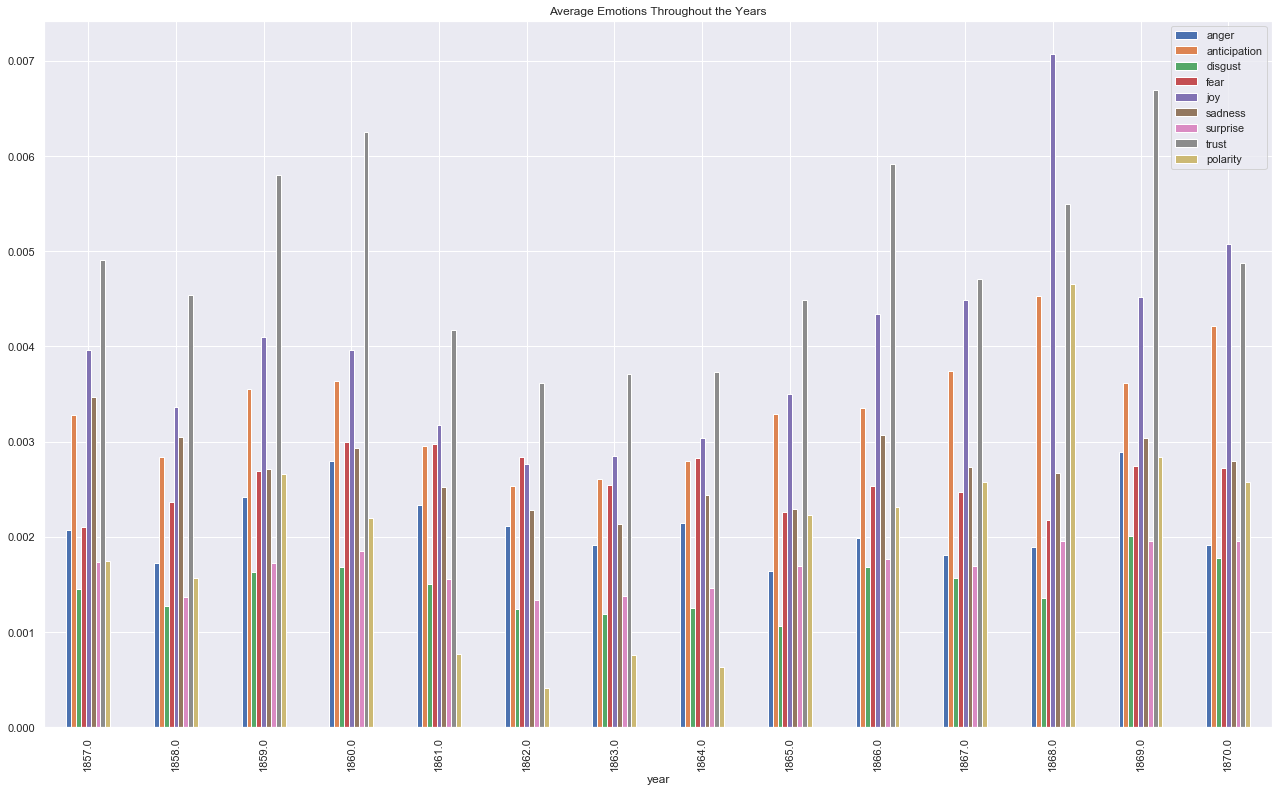

In [497]:
EMO_YEAR = B.groupby(['year'])[emo_cols].mean()

years = list(range(1857,1871))
EMO_YEAR = EMO_YEAR[EMO_YEAR.index.isin(years)]

fig,ax = plt.subplots()
plt.title('Average Emotions Throughout the Years')
EMO_YEAR.plot.bar(figsize=(22,13), ax=ax)
plt.show()

Difference in emotion words between years (1858 = 1858-1857). During the war, it looks like most mean emotion values drop only slightly, but the most variation comes during before and after the war. This may just be a side effect of more of the corpus originating during war years, thus bringing down the averages. Could try taking the median? (that doesn't seem to give the best results, pretty much all years stay the same across years??? prolly cuz theyre on a scale of -1 to 1)

Interesting to see how anticipation and fear increase before the war increases a fair amount. Perhaps disgust after the war isn't too far off? However generally all of the emotions increase at some point before the war. 

In [362]:
hi = EMO_YEAR.diff().max().max() + 0.2
lo = EMO_YEAR.diff().min().min() - 0.2
EMO_YEAR.diff().iloc[1:].style.background_gradient(cmap='RdYlBu', low=lo, high=hi)

,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,polarity
year,,,,,,,,,
1858.0,-0.000340,-0.000444,-0.000180,0.000270,-0.000595,-0.000416,-0.000362,-0.000366,-0.000176
1859.0,0.000688,0.000715,0.000359,0.000321,0.000735,-0.000331,0.000355,0.001262,0.001086
1860.0,0.000382,0.000090,0.000055,0.000307,-0.000144,0.000220,0.000124,0.000449,-0.000455
1861.0,-0.000465,-0.000686,-0.000179,-0.000024,-0.000782,-0.000409,-0.000295,-0.002086,-0.001433
1862.0,-0.000218,-0.000426,-0.000268,-0.000137,-0.000406,-0.000249,-0.000218,-0.000551,-0.000352
1863.0,-0.000199,0.000077,-0.000053,-0.000295,0.000085,-0.000143,0.000040,0.000091,0.000347
1864.0,0.000234,0.000191,0.000066,0.000286,0.000188,0.000298,0.000086,0.000022,-0.000128
1865.0,-0.000507,0.000490,-0.000193,-0.000571,0.000460,-0.000137,0.000236,0.000756,0.001597
1866.0,0.000342,0.000065,0.000622,0.000280,0.000840,0.000776,0.000067,0.001431,0.000085


# Average Emotion separated by County

I'm definitely thinking the amount of observations are inversely proportional to the average scores across each emotion category (high values for 1868, Franklin, 4 observations). Even still, perhaps the rank order of emotion is still helpful. 

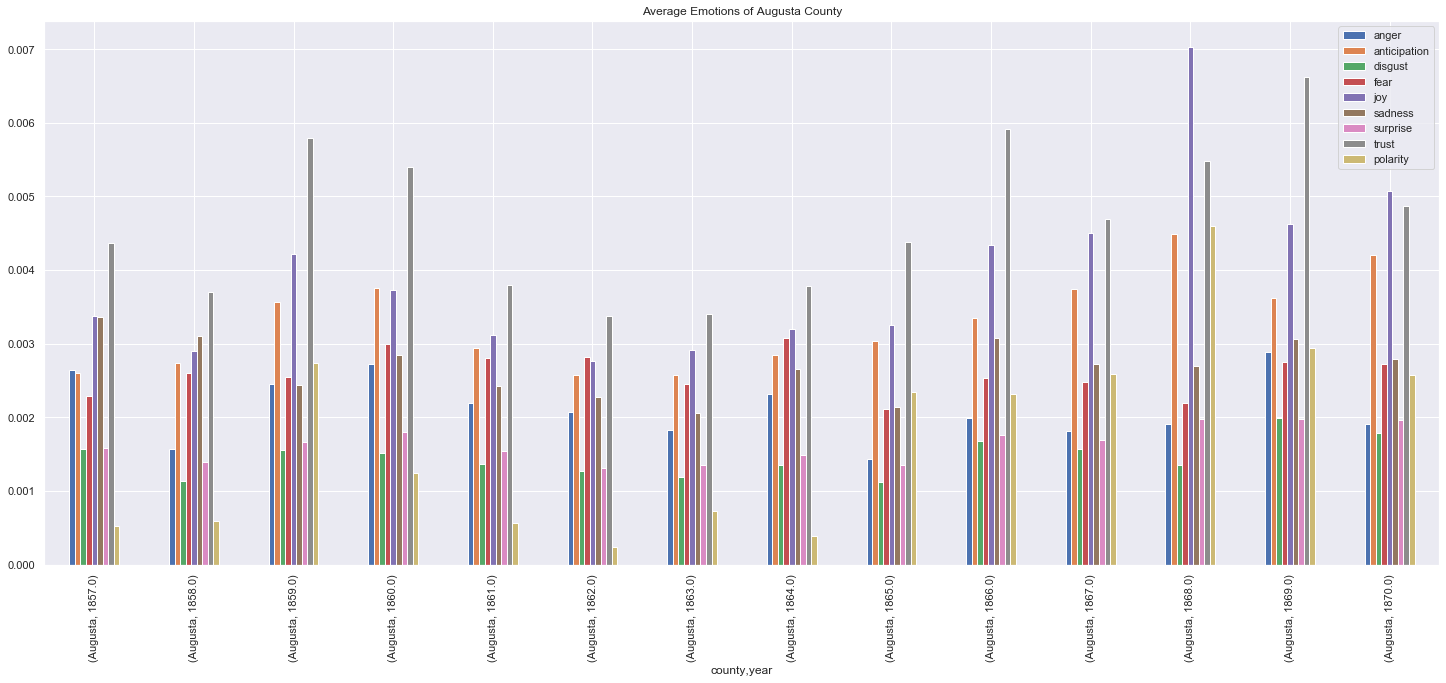

In [363]:
EMO_A = B.groupby(['county','year'])[emo_cols].mean()
county_years = [('Augusta', year) for year in years]
EMO_A = EMO_A.filter(county_years, axis=0)

fig,ax = plt.subplots()
plt.title('Average Emotions of Augusta County')
EMO_A.plot.bar(figsize=(25,10), ax=ax)
plt.show()

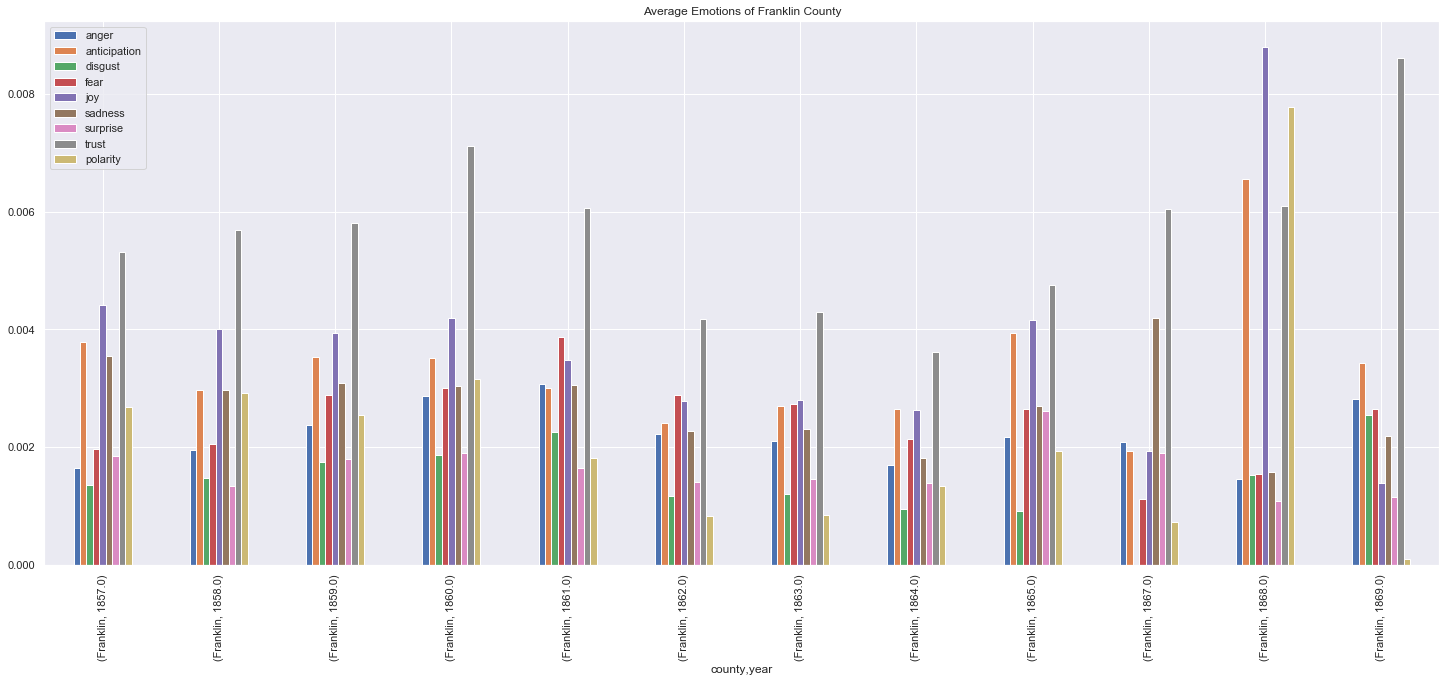

In [364]:
EMO_F = B.groupby(['county','year'])[emo_cols].mean()
county_years = [('Franklin', year) for year in years]
EMO_F = EMO_F.filter(county_years, axis=0)

fig,ax = plt.subplots()
plt.title('Average Emotions of Franklin County')
EMO_F.plot.bar(figsize=(25,10), ax=ax)
plt.show()

Heatmaps of the differences between years and comparisons between counties.

Its interesting to see fear increase for both counties, especially for Augusta towards the end of the war. Generally Augusta has more anticipation and anger during the war, while Franklin has more disgust before the war, and sadness during the war. 

In [365]:
hi = EMO_A.diff().max().max() + 0.2
lo = EMO_A.diff().min().min() - 0.2
EMO_A.diff().iloc[1:].style.background_gradient(cmap='RdYlBu', low=lo, high=hi)

In [366]:
hi = EMO_F.diff().max().max() + 0.2
lo = EMO_F.diff().min().min() - 0.2
EMO_F.diff().iloc[1:].style.background_gradient(cmap='RdYlBu', low=lo, high=hi)

# Average Emotion for Reoccuring Authors

Want to look at the more prevelant authors, and track the sentiment over time. Hopefully we can do this for authors from both counties.

In [492]:
def plot_sentiments(df, emo='polarity'):
    FIG = dict(figsize=(20, 10), legend=True, fontsize=18, rot=45)
    df[emo].plot(**FIG)
    
def plot_sentiments_px(df, x):
    df = df.stack().to_frame().reset_index().rename(columns={0:'value','level_4':'emo'})
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
    return px.line(df, x=x, y='value', color='emo')

In [446]:
LIB.groupby(['author','county']).author.value_counts().sort_values(ascending=False)[0:10]

author                         county    author                       
Jedediah Hotchkiss             Augusta   Jedediah Hotchkiss               187
John Scott                     Augusta   John Scott                        71
David H. Evans                 Augusta   David H. Evans                    53
Alexander K. McClure           Franklin  Alexander K. McClure              52
John Quincy Adams Nadenbousch  Augusta   John Quincy Adams Nadenbousch     47
Mary Anna Sibert               Augusta   Mary Anna Sibert                  44
David Demus                    Franklin  David Demus                       41
Samuel M. Potter               Franklin  Samuel M. Potter                  31
William F. Brand               Augusta   William F. Brand                  29
Franklin Rosenbery             Franklin  Franklin Rosenbery                29
Name: author, dtype: int64

Jedediah Hotchkiss is most active during the years of the civil war.

In [482]:
years=list(range(1861, 1866))

hotchkiss = B.query('author == "Jedediah Hotchkiss"').groupby(['author', 'year', 'month'])[emo_cols].mean()
hotchkiss = hotchkiss.reset_index()[hotchkiss.reset_index().year.isin(years)].set_index(['author', 'year', 'month'])
hotchkiss.head()

anger  anticipation   disgust      fear  \
author             year   month                                               
Jedediah Hotchkiss 1861.0 6.0    0.001566      0.002411  0.000369  0.001783   
                          7.0    0.001401      0.002161  0.001175  0.001923   
                          8.0    0.001077      0.002168  0.000868  0.001347   
                          9.0    0.001510      0.001957  0.001562  0.001580   
                   1862.0 3.0    0.002433      0.002493  0.001371  0.003932   

                                      joy   sadness  surprise     trust  \
author             year   month                                           
Jedediah Hotchkiss 1861.0 6.0    0.002859  0.001492  0.000442  0.002628   
                          7.0    0.002489  0.001487  0.001351  0.002856   
                          8.0    0.002535  0.001558  0.001392  0.002795   
                          9.0    0.003458  0.002630  0.000398  0.003049   
                   1862.0 3.0    0.003236  0.003357  0.001179  0.002462   

                                 polarity  
author             year   month            
Jedediah Hotchkiss 1861.0 6.0    0.001528  
                          7.0    0.000858  
                          8.0    0.001407  
                          9.0    0.001156  
                   1862.0 3.0   -0.000974

The average emotions of Hotchiss' letters over time. Upon inspextion of the large peaks, it seems brief letters are likely to result in mean scores of much larger magnitude. The smaller values provide more insight. 

Interesting to see a dip in polarity around May 1863 and after, around the death of General "Stonewall" Jackson. It was his brigade which Hotchkiss was a topographical engineer, and traveled with them since 1862

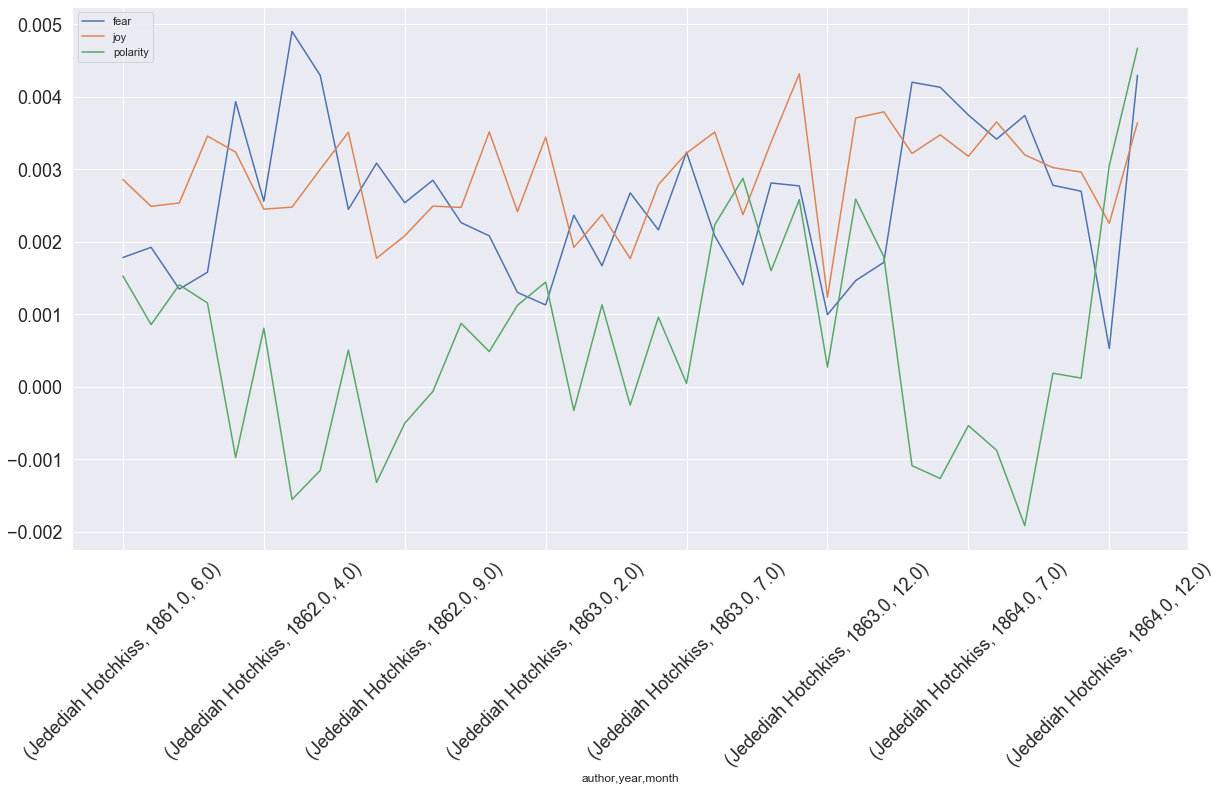

In [493]:
plot_sentiments(hotchkiss, ['fear', 'joy','polarity'])

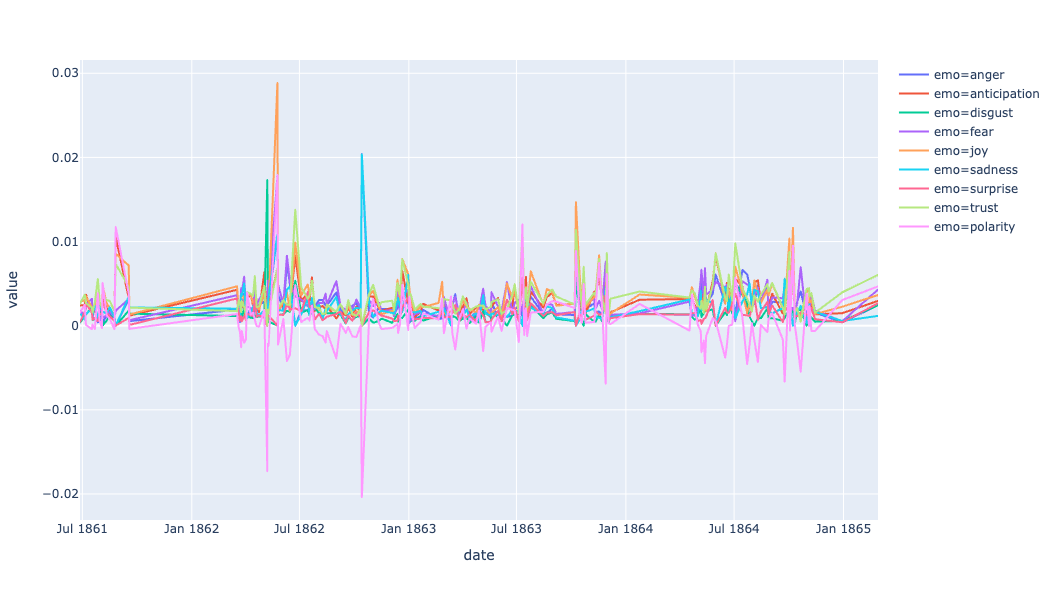

In [469]:
plot_sentiments_px(hotchkiss, x='date')

In [479]:
years=list(range(1861, 1865))

mcclure = B.query('author == "Alexander K. McClure"').groupby(['author', 'year', 'month'])[emo_cols].mean()
mcclure = mcclure.reset_index()[mcclure.reset_index().year.isin(years)].set_index(['author', 'year', 'month'])

Looking at the emotional timeline of Alexander McClure, trends in the polarity can be backed up by reading some of the letters from those months. He bemoans the loss at Manassas in July '61, he expresses the merits of soliders in July '62, and starts to express his confidence in winning an upcoming election for Pennsylvania state legislature in '64

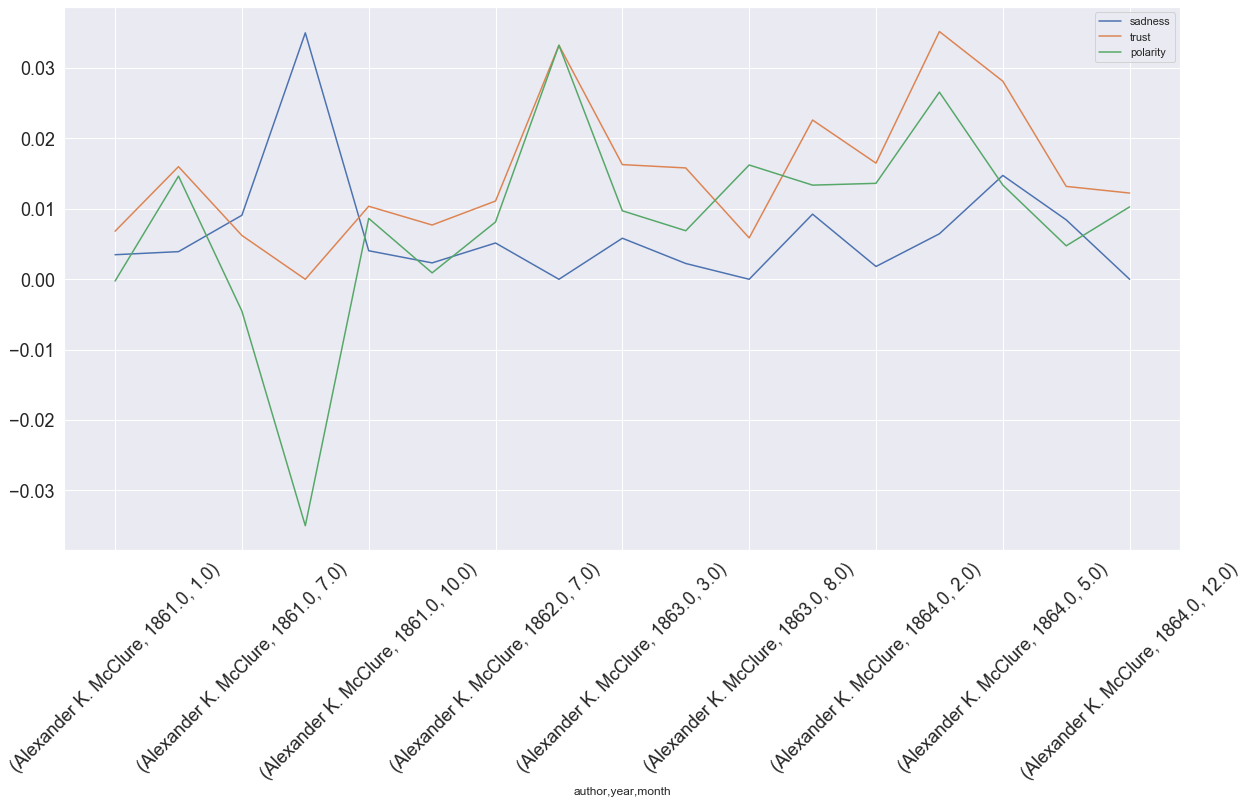

In [494]:
plot_sentiments(mcclure, ['sadness','trust','polarity'])

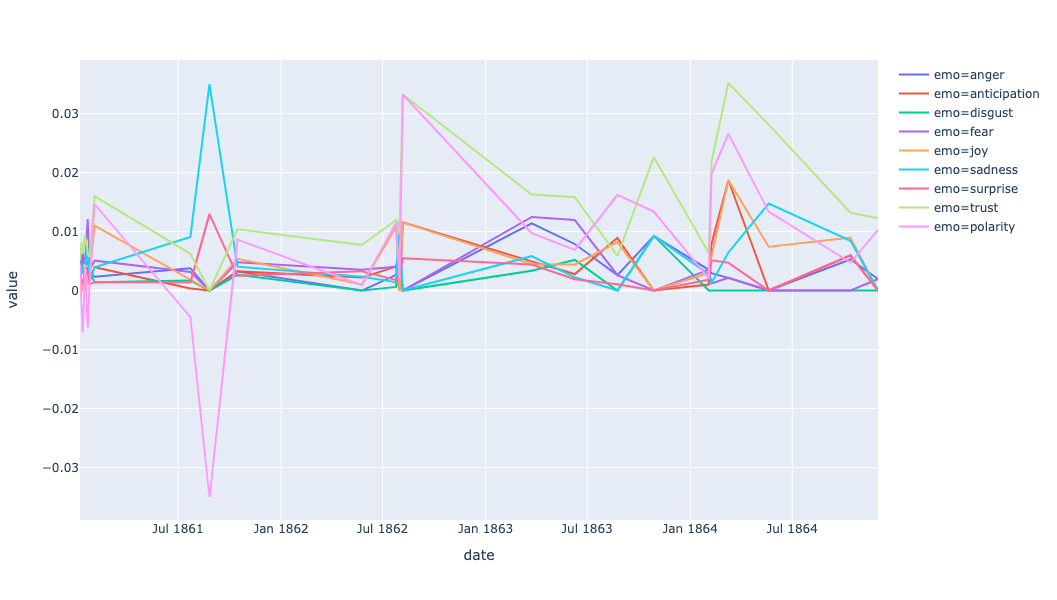

In [477]:
plot_sentiments_px(mcclure, x='date')

# Conclusions
For lexicon based approach, the bargraphs and overall average emotion scores seem to depend on the number of observations per year. More variation during eve and post-war years for this reason, however, it is possible to pick out some differences between counties by looking at trends between years.

I bet the positive emotions like joy would decrease significantly if I were to filter out the beginning salutions and complimentary closings for each letter, while leaving in the post scripts.